In [1]:
## pc LABO--------------
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyvisa
import pandas as pd
import nysg_tools as ny
import time

In [ ]:
## COLAB---------------
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
#import pyvisa
import pandas as pd
!pip install nysg_tools
import nysg_tools as ny
import time

In [2]:
rm = pyvisa.ResourceManager()
rm.list_resources()

('USB0::0x0699::0x0368::C017067::INSTR',
 'USB0::0x0699::0x0353::1915134::INSTR',
 'ASRL1::INSTR',
 'ASRL10::INSTR')

In [3]:
osci_name = "USB0::0x0699::0x0368::C017067::INSTR"
fungen_name = "USB0::0x0699::0x0353::1915134::INSTR"

osci = rm.open_resource(osci_name)
fungen = rm.open_resource(fungen_name)

# CH1 -> INPUT
# CH2 -> OUTPUT

In [4]:
def get_osci(additional_info = False, plot=False):
    osci.write("DAT:SOU CH1")
    xze, xin = osci.query_ascii_values('WFMPRE:XZE?;XIN?', separator=';')
    yze1, ymu1, yoff1 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')
    osci.write("DAT:SOU CH2")

    yze2, ymu2, yoff2 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')

    osci.write('DAT:ENC RPB')
    osci.write('DAT:WID 1')

    osci.write("DAT:SOU CH1")
    data1 = osci.query_binary_values('CURV?', datatype='B', container=np.array)

    osci.write("DAT:SOU CH2")
    data2 = osci.query_binary_values('CURV?', datatype='B', container=np.array)

    tiempo = xze + np.arange(len(data1)) * xin

    data1v = (data1 - yoff1) * ymu1 + yze1
    data2v = (data2 - yoff2) * ymu2 + yze2

    if plot:
        plt.plot(tiempo,data1v)
        plt.plot(tiempo,data2v)

    if additional_info:
        extra = {"yze1":yze1,"ymu1":ymu1,"yoff1":yoff1,"yze2":yze2,"ymu2":ymu2,"yoff2":yoff2,"datach1raw":data1,"datach2raw":data2}
        return tiempo,data1v,data2v, extra

    return tiempo,data1v,data2v

def osci_autosave(filename,attrs,plot_saved=False):
    t,v1,v2 = get_osci()
    buffer =  pd.DataFrame({"time":t,"VCH1":v1,"VCH2":v2})

    buffer.attrs = attrs

    buffer.to_csv(f'{filename}{".csv"}')
    buffer.to_pickle(f'{filename}')

    if plot_saved:
        plt.plot(t,v1)
        plt.plot(t,v2)

def osci_autosave_nocsv(filename,attrs,plot_saved=False):
    t,v1,v2 = get_osci()
    buffer =  pd.DataFrame({"time":t,"VCH1":v1,"VCH2":v2})

    buffer.attrs = attrs
    buffer.to_pickle(f'{filename}')

    if plot_saved:
        plt.plot(t,v1)
        plt.plot(t,v2)

def osci_autosave_simple(filename):
    t,v1,v2 = get_osci()
    buffer =  pd.DataFrame({"time":t,"VCH1":v1,"VCH2":v2})

    buffer.to_pickle(f'{filename}')

In [23]:

##Valores asociados a "Data1/"

freq = np.linspace(60,40e3,40)  
overf = 1/np.array(freq)

for (i,freq) in enumerate(freq):
     fungen.write(f'SOURCE1:FREQ {freq}')
     osci.write(f"HOR:MAI:SCALE {3/10 * 0.8 *overf[i]}")
     time.sleep(0.5)
     #osci_autosave_simple(f"data1/med{i}")

#para data1:
#attrs = {"Freq_in":freq, "Res":111,"vpp_in":8,"n1":200,"n2":1600,"vscaleout":5,"vscalein":1}


In [29]:
# Data 2 Cambio de N2 con N1 fijo, a V fijo y frec Fija 

V_in = 1 # en V
freq = 1000 # en Hz
N1=200
N2=np.array([1600,800,400,3200])
v_in_medido=np.array([.800,.800,.800,0.778])
v_in_medido_err=np.array([0.002,0.002,.002,.004])
v_out=np.array([1.8,0.88,0.44,3.44])
v_out_err=np.array([.04,0.008,0.008,0.02])

In [43]:
np.argsort(N2)

array([2, 1, 0, 3], dtype=int64)

In [44]:
N2[np.argsort(N2)]
v_out[np.argsort(N2)]

array([0.44, 0.88, 1.8 , 3.44])

<ErrorbarContainer object of 3 artists>

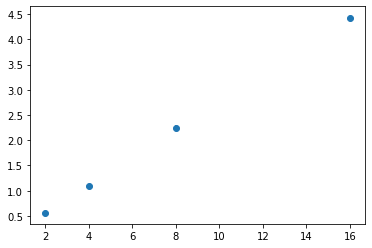

In [47]:
y, yerr = ny.propagate("a/b",a=(v_out[np.argsort(N2)],v_out_err[np.argsort(N2)]),b=(v_in_medido[np.argsort(N2)], v_in_medido_err[np.argsort(N2)] ))
x = N2[np.argsort(N2)]/N1

plt.errorbar(x,y, yerr=yerr,fmt="o")


In [54]:
def lineal(x,m,b):
   return x*m+b

p0 = [1,1]

p = ny.fit_lsq(x,y,yerr=yerr,func=lineal,p0=[0,0])


La función es:
None
Resultados del ajuste:
Parámetro m: 0.277 ± 0.001
Parámetro b: -0.005 ± 0.007
Parametros de bondad:
ν: 1
χ²: 0.713
χ²/ν:0.713
Criterio 5%: (-1.333, 3.333)


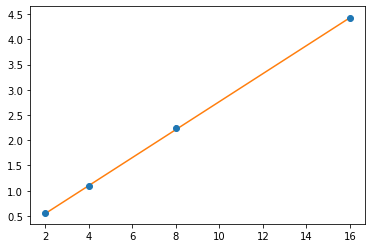

In [56]:
plt.errorbar(x,y, yerr=yerr,fmt="o")

plt.plot(x,lineal(x,*p["params"]))

In [67]:

##Valores asociados a "Data2/" sin nucleo de hierro 

# freq1 = np.linspace(4000,90e3,50)  
# freq2 = np.linspace(27e3,40e3,20)
# freq = np.sort(np.append(freq1,freq2))
# overf = 1/np.array(freq)

# for (i,freq) in enumerate(freq):
#      fungen.write(f'SOURCE1:FREQ {freq}')
#      osci.write(f"HOR:MAI:SCALE {3/10 * 0.8 *overf[i]}")
#      time.sleep(0.1)
#      osci_autosave_simple(f"data2/med{i}")

#para data1:
#attrs = {"Freq_in":freq, "Res":111,"vpp_in":5,"vscaleout":2,"vscalein":.5}

In [68]:

##Valores asociados a "Data3/" CON nucleo de hierro 

# freq1 = np.linspace(4000,90e3,50)  
# freq2 = np.linspace(27e3,40e3,20)
# freq = np.sort(np.append(freq1,freq2))
# overf = 1/np.array(freq)

# for (i,freq) in enumerate(freq):
#      fungen.write(f'SOURCE1:FREQ {freq}')
#      osci.write(f"HOR:MAI:SCALE {3/10 * 0.8 *overf[i]}")
#      time.sleep(0.1)
#      osci_autosave_simple(f"data3/med{i}")

#para data1:
#attrs = {"Freq_in":freq, "Res":111,"vpp_in":5,"vscaleout":2,"vscalein":.5}

In [71]:
pd.read_pickle(f"data2/med{1}")

,time,VCH1,VCH2
0,-0.000250,-0.48,-0.74
1,-0.000250,-0.56,-0.74
2,-0.000250,-0.48,-0.78
3,-0.000249,-0.48,-0.78
4,-0.000249,-0.48,-0.78
...,...,...,...
2495,0.000249,-0.32,0.62
2496,0.000249,-0.32,0.62
2497,0.000249,-0.32,0.60
2498,0.000250,-0.32,0.56


In [80]:
freq1 = np.linspace(4000,90e3,50)  
freq2 = np.linspace(27e3,40e3,20)
freq = np.sort(np.append(freq1,freq2))



vin1= np.array([])
vout1= np.array([])

vin2 = np.array([])
vout2= np.array([])
for (i,val) in enumerate(freq):
    buff = pd.read_pickle(f"data2/med{i}")
    buff2 = pd.read_pickle(f"data3/med{i}")

    vin1 = np.append(vin1,np.max(buff['VCH2']))
    vout1 = np.append(vout1,np.max(buff['VCH1']))

    vin2 = np.append(vin2,np.max(buff2['VCH2']))
    vout2 = np.append(vout2,np.max(buff2['VCH1']))


In [106]:
pop = pd.read_pickle(f"data2/med67")

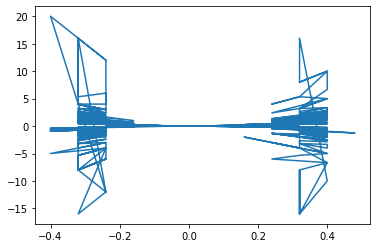

In [120]:
plt.plot(pop["VCH1"],pop["VCH1"]/pop["VCH2"])


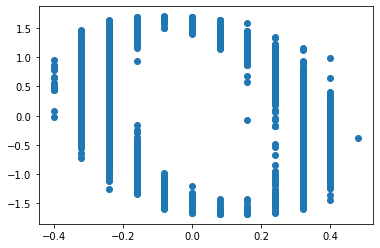

In [107]:
plt.scatter(pop["VCH1"],pop["VCH2"])

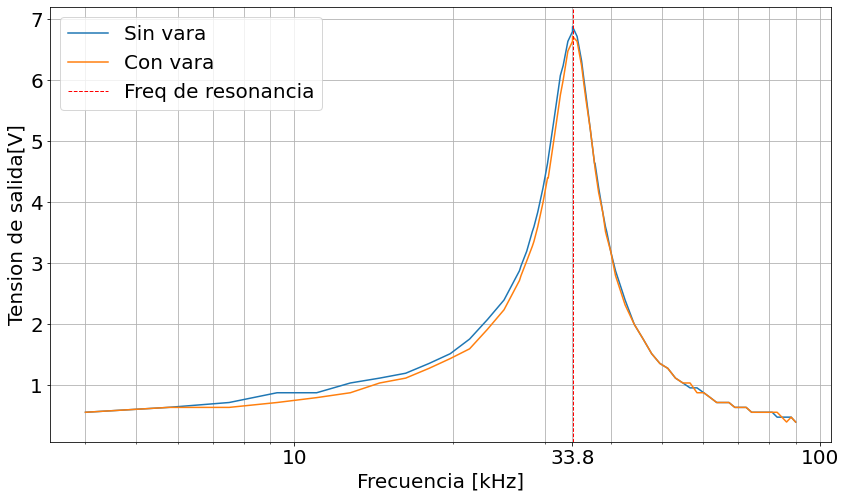

In [172]:
# plt.rcParams.update = fontsize
plt.rcParams['font.size'] = 20
plt.figure(figsize=(14,8))

plt.plot(freq,vout1,label="Sin vara")
plt.plot(freq,vout2,label="Con vara")
plt.xscale("log")
# plt.xlim(10**4,10**5)
plt.axvline(freq[28],linewidth=1,linestyle="--",c='red',label=f"Freq de resonancia")
plt.grid(which="both")
plt.xticks([1*10**4,3.38*10**4,1*10**5],["10","33.8","100"])
plt.ylabel("Tension de salida[V]")
plt.xlabel("Frecuencia [kHz]")
plt.xticks()
plt.legend()
#plt.savefig("barrido.pdf",dpi=300)

In [149]:
freq[28]

33842.10526315789

In [139]:
from scipy.signal import find_peaks

In [140]:
find_peaks(vout1)

(array([28], dtype=int64), {})

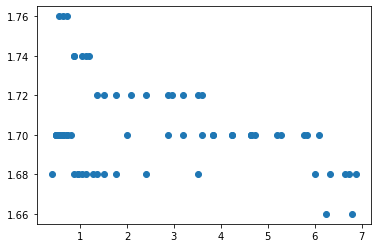

In [86]:
plt.scatter(vout1,vin1)

In [180]:
np.linspace(20,1000,50)


array([  20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,  180.,
        200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,  360.,
        380.,  400.,  420.,  440.,  460.,  480.,  500.,  520.,  540.,
        560.,  580.,  600.,  620.,  640.,  660.,  680.,  700.,  720.,
        740.,  760.,  780.,  800.,  820.,  840.,  860.,  880.,  900.,
        920.,  940.,  960.,  980., 1000.])

In [9]:
#data ultima desesperado

##Valores asociados a "Data1/"

freq = np.linspace(20,1000,50)  
overf = 1/np.array(freq)

for (i,freq) in enumerate(freq):
     fungen.write(f'SOURCE1:FREQ {freq}')
     osci.write(f"HOR:MAI:SCALE {3/10 * 0.8 *overf[i]}")
     osci_autosave_simple(f"data4rlc/med{i}")

#para data1:
#attrs = {"Freq_in":freq, "Res":111,"vpp_in":8,"n1":200,"n2":1600,"vscaleout":5,"vscalein":1}



VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.